<a href="https://colab.research.google.com/github/EduardEreshko/face-recognition/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import albumentations as A
from albumentations import HorizontalFlip, ShiftScaleRotate

# Функции

In [27]:
def get_aug(image):
    angle = np.arange(-10, 11, 1)
    angle0 = random.choice(angle)
    shift = 0.01 * np.arange(-10, 11, 1)
    shift0 = random.choice(shift)
    transform = A.ShiftScaleRotate(
        shift_limit=shift0,
        rotate_limit=angle0,
        scale_limit=0,
        p=0.5
    )
    augmented_image = transform(image=image)['image']
    transform = A.HorizontalFlip(p=0.5)
    return transform(image=augmented_image)['image']

def filter_directories(dirname):
    image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp'}
    valid_directories = []

    for item in os.listdir(dirname):
        full_path = os.path.join(dirname, item)
        if not os.path.isdir(full_path):
            continue

        try:
            # Быстрая проверка первых 5 файлов
            files = os.listdir(full_path)[:5]
            if not files:  # пустая директория
                continue

            if all(os.path.splitext(f)[1].lower() in image_extensions
                   for f in files if os.path.isfile(os.path.join(full_path, f))):
                valid_directories.append(item)
        except (PermissionError, OSError) as e:
            print(f"Error accessing {full_path}: {e}")
            continue

    return valid_directories

# Обработка изображений

In [28]:
dirname = "/content/drive/MyDrive/Stepik/Старт в ML: создайте свою систему распознавания лиц/Start_ML"
labels = filter_directories(dirname)[:126:25]  # чтобы долго не ждать обработки проходимся лишь по некоторым папкам с изображениями

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
X, y = [], []

for label in labels:
    subdir = os.path.join(dirname, label)
    filelist = os.listdir(subdir)
    for fname in filelist:
        img_path = os.path.join(subdir, fname)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f'Failed to load image: {img_path}')
            continue

        img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)

        faces = face_cascade.detectMultiScale(img)
        if len(faces) == 0:
            print(f'no face found for {fname}')
            continue

        # Берем первое найденное лицо
        (a, b, w, h) = faces[0]
        face_img = img[b:b + h, a:a + w]

        try:
            h_face, w_face = face_img.shape
            size = min(h_face, w_face)
            h0 = int((h_face - size) / 2)
            w0 = int((w_face - size) / 2)
            cropped_face = face_img[h0: h0 + size, w0: w0 + size]
            cropped_face = cv2.resize(cropped_face, (64, 64), interpolation=cv2.INTER_AREA)
            X.append(cropped_face)
            y.append(label)
        except Exception as e:
            print(f'Error processing {fname}: {e}')

len(X), len(y)

no face found for Screenshot_19.jpg
no face found for Screenshot_24.jpg
no face found for Screenshot_25.jpg
no face found for IMG_9797.JPEG
no face found for IMG_8989.JPEG
no face found for IMG_7202.JPEG
no face found for IMG_1493.JPEG
no face found for IMG_0373.JPEG
no face found for IMG_9567.JPG
no face found for IMG_9122.JPG
no face found for IMG_0198.JPG
no face found for 6.png
no face found for 15.png
no face found for oZVDEicU9_ytl1yx4rCKATBgbHbF5W5Dngo47nnSojCKNtWU43gHWl7imk2OgQftZp0LRu0I.jpg
no face found for 36.png
no face found for Screen-Captures-H2O-Just-Add-Water-2x07-In-Hot-Water-claire-holt-25571456-592-336.png
no face found for 5db94eb1f94448cc337f926288fbb564--ho-mermaids-claire-holt.jpg
no face found for Screen-Captures-H2O-Just-Add-Water-2x03-Double-Trouble-claire-holt-24716056-1047-576.png
no face found for Screen-Captures-H2O-Just-Add-Water-2x04-Emma-Rebel-claire-holt-24867962-1047-576.png
no face found for Screen-Captures-H2O-Just-Add-Water-1x14-Surprise-claire-ho

(5279, 5279)

# Вывод 5 обработанных фотографий

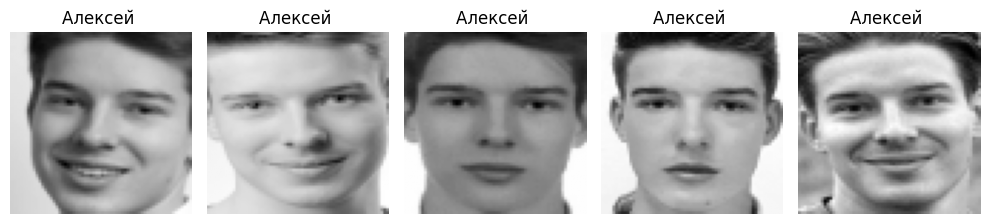

In [29]:
fig, axx = plt.subplots(1, 5, figsize=(10, 5))
for i in range(5):
    img = X[i]
    axx[i].imshow(img, cmap='gray')
    axx[i].set_title(y[i])
    axx[i].axis('off')
plt.tight_layout()
plt.show()

# Разделение на тестовую и тренировочную выборку

In [30]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y, random_state=42)

# Нормализуем
Xtrain_flat = np.asarray([el.ravel() for el in Xtrain], dtype=np.float32) / 255.0
Xtest_flat = np.asarray([el.ravel() for el in Xtest], dtype=np.float32) / 255.0

In [31]:
len(Xtrain), len(Xtest)

(3959, 1320)

# Создание модели с StandardScaler и KernelPCA

In [32]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

pca = KernelPCA(n_components=200, kernel='poly', random_state=42)
scaler = StandardScaler()
model_lr = LogisticRegression(random_state=42, max_iter=1000)
model = make_pipeline(scaler, pca, model_lr)

# Аугментация изображений, обучение модели, вывод метрик

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Number of augmentations: 1, Accuracy: 0.5606



/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Number of augmentations: 3, Accuracy: 0.5705



/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Number of augmentations: 5, Accuracy: 0.5818

=== Classification Report ===
                           precision    recall  f1-score   support

                 benedict       0.45      0.42      0.43        12
                       AA       0.58      0.52      0.55        21
              Aleksandr V       0.70      0.54      0.61        13
          Aleksandr_Zmeev       0.50      0.47      0.48        17
                 Alexeeva       1.00      0.58      0.74        12
           Alexey_Novikov       0.56      0.64      0.60        14
             Alla Zhukova       0.31      0.42      0.36        12
                    Amber       0.25      0.14      0.18        14
            Amy Winehouse       0.43      0.50      0.46        12
                     Anka       0.62      0.62      0.62        13
     Brian 'Limmy' Limond       0.62      0.67      0.64        12
           Britney Spears       0.69      0.65      0.67        17
           Christian Bale       0.14      0.08      

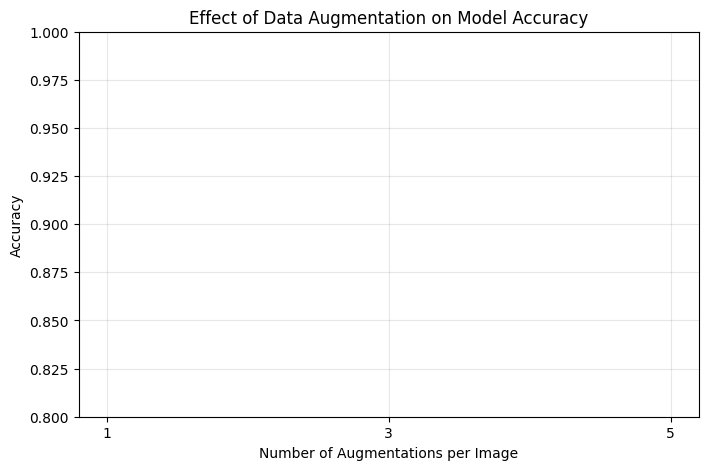

The average value of the accuracy: 0.5710


In [33]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_model(num_augmentations):
    XtrainAug = []
    ytrainAug = []

    for (img, label) in zip(Xtrain, ytrain):
        # Всегда добавляем оригинальное изображение
        XtrainAug.append(img)
        ytrainAug.append(label)

        # Добавляем аугментированные версии
        for i in range(num_augmentations):
            aug_img = get_aug(img)
            XtrainAug.append(aug_img)
            ytrainAug.append(label)

    # Преобразуем и нормализуем
    XtrainAug_flat = np.asarray([el.ravel() for el in XtrainAug], dtype=np.float32) / 255.0

    model.fit(XtrainAug_flat, ytrainAug)
    pred = model.predict(Xtest_flat)

    acc = accuracy_score(ytest, pred)
    return acc, pred

results = {}
mid_acc = 0


for num_augmentations in range(1, 6, 2):
    accuracy, predictions = evaluate_model(num_augmentations)
    results[num_augmentations] = accuracy
    print(f'Number of augmentations: {num_augmentations}, Accuracy: {accuracy:.4f}\n')

    if num_augmentations == 5:
        print("=== Classification Report ===")
        print(classification_report(ytest, predictions))
        print("\n=== Confusion Matrix ===")
        print(confusion_matrix(ytest, predictions))

    mid_acc += accuracy

# График
plt.figure(figsize=(8, 5))
plt.plot(results.keys(), results.values(), marker='o', linestyle='-', color='b')
plt.xlabel('Number of Augmentations per Image')
plt.ylabel('Accuracy')
plt.title('Effect of Data Augmentation on Model Accuracy')
plt.grid(True, alpha=0.3)
plt.xticks(list(results.keys()))
plt.ylim(0.3, 1.0)
plt.show()

print(f"The average value of the accuracy: {mid_acc / len(results):.4f}")

# Визуализация предсказаний

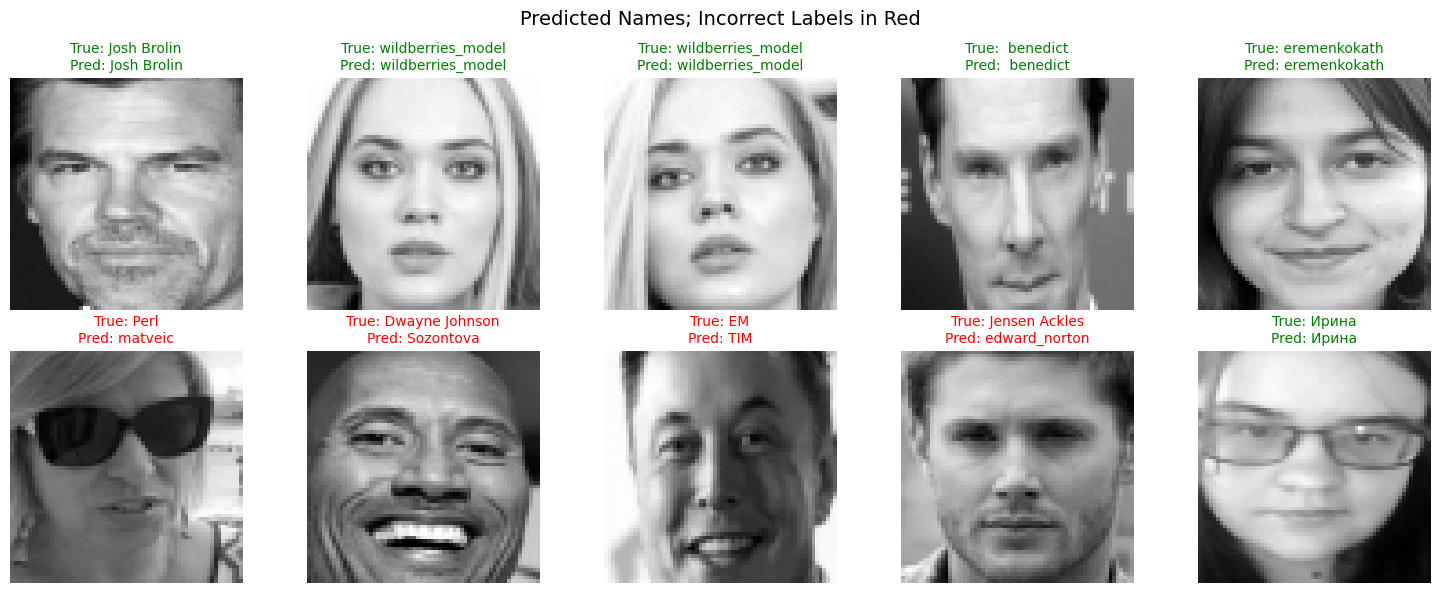

In [34]:
def plot_predictions_with_labels(Xtest_list, ytest_list, pred_list, n_images=10):
    """Отображает изображения с истинными и предсказанными метками."""
    n_rows = 2
    n_cols = n_images // n_rows
    fig, axx = plt.subplots(n_rows, n_cols, figsize=(15, 6))
    axx = axx.flatten()

    for i in range(min(n_images, len(Xtest_list))):
        axx[i].imshow(Xtest_list[i].reshape(64, 64), cmap='gray')
        true_label = ytest_list[i]
        pred_label = pred_list[i]
        title = f"True: {true_label}\nPred: {pred_label}"
        if true_label != pred_label:
            axx[i].set_title(title, color='red', fontsize=10)
        else:
            axx[i].set_title(title, color='green', fontsize=10)
        axx[i].axis('off')

    plt.suptitle('Predicted Names; Incorrect Labels in Red', fontsize=14)
    plt.tight_layout()
    plt.show()

# Визуализируем последние предсказания (для num_augmentations=3)
plot_predictions_with_labels(Xtest, ytest, predictions, n_images=10)